In [1]:
%load_ext autoreload
%autoreload 2
# imports

# important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp

from tqdm.auto import tqdm
import itertools

# for better printing of variables
from IPython.display import display

# custom imports
from concperf import single_model, general_model
from concperf import utility

In [2]:
# update configuration dictionary for each instance count
def update_config(config):
    config['arrival_rate_server'] = config['arrival_rate_total'] / config['instance_count']
    config['base_service_time'] = config['base_service_time_ms'] / 1000
    config['stable_conc_avg_count'] = 10 * config['instance_count']

# target utilization
target_util = 0.7
    
model_config = {
    # 'instance_count' should be added for each state
    'max_conc': 10,
    'arrival_rate_total': 15,
    'alpha': 0.102,
    'base_service_time_ms': 1180,
    'max_container_count': 50,
    'target_conc': 5*target_util, # assumes target utilization
    'max_scale_up_rate': 1000, # from N to 1000*N at most
    'max_scale_down_rate': 2, # from N to N/2 at most
    # 'stable_conc_avg_count': 60, # number of times monitored concurrency will be averaged in stable mode
    'autoscaling_interval': 2, # amount of time between autoscaling evaluations
    'provision_rate_base': 1,
    'deprovision_rate_base': 2,
}

# test
# model_config = {
#     # 'instance_count' should be added for each state
#     'max_conc': 100,
#     'arrival_rate_total': 15,
#     'alpha': 1,
#     'base_service_time_ms': 400,
#     'max_container_count': 25,
#     'target_conc': 16*0.7, # assumes target utilization
#     'max_scale_up_rate': 1000, # from N to 1000*N at most
#     'max_scale_down_rate': 2, # from N to N/2 at most
#     # 'stable_conc_avg_count': 60, # number of times monitored concurrency will be averaged in stable mode
#     'autoscaling_interval': 2, # amount of time between autoscaling evaluations
#     'provision_rate_base': 1,
#     'deprovision_rate_base': 2,
# }

In [3]:
res = general_model.solve_general_model(model_config, update_config, show_progress=True)
res.keys()

  0%|          | 0/51 [00:00<?, ?it/s]

dict_keys(['inst_count_possible_values', 'inst_count_probs', 'ready_probs', 'ordered_probs', 'req_count_probs', 'req_count_values'])

instances: 7.40055384821758 ready / 7.43757783611451 ordered


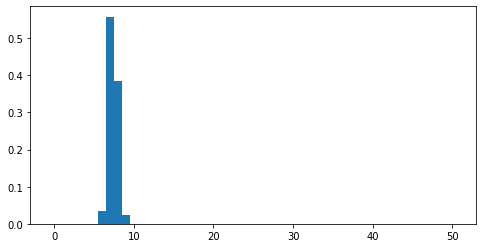

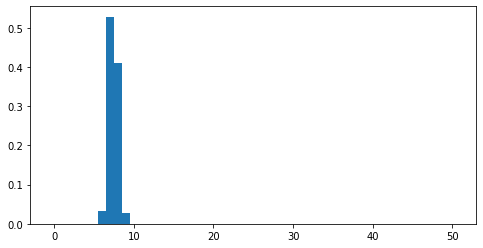

In [4]:
plt.figure(figsize=(8,4))
plt.bar(res['inst_count_possible_values'], res['ready_probs'], width=1)
plt.figure(figsize=(8,4))
plt.bar(res['inst_count_possible_values'], res['ordered_probs'], width=1)

ready_avg = (res['inst_count_possible_values'] * res['ready_probs']).sum()
ordered_avg = (res['inst_count_possible_values'] * res['ordered_probs']).sum()


print(f"instances: {ready_avg} ready / {ordered_avg} ordered")

(51, 100)
(51,)
Average Request Count In Each Container: 3.3053161967212477


(-1.0, 10.0)

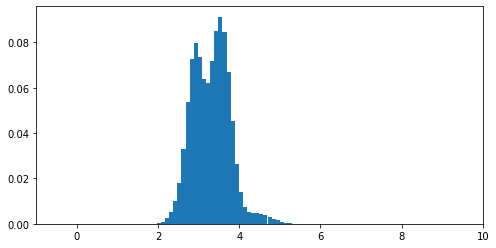

In [5]:
# weighted probability of request count in each container
print(res['req_count_probs'].shape)
print(res['ready_probs'].shape)

req_count_probs_weighted = res['req_count_probs'].T @ res['ready_probs']
req_count_avg = (res['req_count_values'] * req_count_probs_weighted).sum()
print('Average Request Count In Each Container:', req_count_avg)

plt.figure(figsize=(8,4))
plt.bar(res['req_count_values'], req_count_probs_weighted, width=0.1)
plt.xlim([-1,10])

In [6]:
resp_time_counts = res['req_count_values'][1:]
resp_time_counts_probs = req_count_probs_weighted[1:] / (1- req_count_probs_weighted[0])
resp_time_values = model_config['base_service_time_ms'] * (1 + (resp_time_counts - 1) * model_config['alpha'])

resp_time_avg = (resp_time_values * resp_time_counts_probs).sum()
print(f'Average Response Time: {resp_time_avg:4.2f}')

Average Response Time: 1457.47
